In [1]:
from lxml import objectify
import pandas as pd
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [2]:
def plot(x,y=None):
    if y==None:
        tmp = range(len(x))
        y = x
        x = tmp
    fig, ax = plt.subplots(figsize=(16,2))
    ax.plot(x,y)
    plt.show()

In [3]:
path=r'dataset/REFIT_BUILDING_SURVEY.xml'
tree = objectify.parse(path)
root = tree.getroot()
NS={'a':'http://www.refitsmarthomes.org'}

path=r'dataset/REFIT_TIME_SERIES_VALUES.csv'

try:
    csv
except:
    csv=pd.read_csv(path, index_col=0, parse_dates=[1])

In [4]:
#Energy consumption in home
def get_energy():
    """
        Available only for 1st building, due to needs a lot of memory on drive
    """
    
    path = r'dataset/CLEAN_House1.csv'
    csvnrg=pd.read_csv(path, header=0,usecols=["Time", "Aggregate"], parse_dates=[0])

    data_en = csvnrg['Aggregate'].tolist()
    time_en = csvnrg['Time'].tolist()

#     plot(time_en, data_en)
    
    return data_en, time_en

In [5]:
#Values of (gas based) Radiator temperature sensor
def get_radiator(building_num=1, rad_num=2):
    appliance = 'Radiator[%d]' % (rad_num)
    NS={'a':'http://www.refitsmarthomes.org'}
    
    radiators = root.xpath('./a:Stock/a:Building[%d]/a:%s' % (building_num, appliance), namespaces=NS)

    data_rad = []
    time_rad = []

    for rad in radiators:
        r_id = rad.get('id')
        t = []
        v = []
        for sensor in rad.getchildren():
            for time_series_variable in sensor.getchildren():
                id = time_series_variable.get('id')
                t.append(csv.loc[id]['dateTime'].tolist())
                v.append(csv.loc[id]['data'].values.tolist())
        data_rad = list(itertools.chain.from_iterable(v))
        time_rad = list(itertools.chain.from_iterable(t))
    
    return data_rad, time_rad

In [6]:
#Summs values for intervals

by_day = lambda t: t.day
by_week = lambda t: t.week
by_month = lambda t: t.month
    
act_sum = lambda s, vi: s + vi
act_max = lambda s, vi: max(s,vi)
act_min = lambda s, vi: min(s,vi)
    
def act_interval(check_param, action, times, values):
    t = []
    v = []
    s = values[0]
    for i in range(1, len(times)):
        if check_param(times[i]) == check_param(times[i-1]):
            s = action(s, values[i])
        else:
            v.append(s)
            t.append(times[i])
            s = values[i]
    return t,v

In [7]:
#Usage of gas in home

def get_gas(building_num=1):
    appliance = 1 #Number of gas meter
    NS={'a':'http://www.refitsmarthomes.org'}
    tsv = root.xpath('./a:Stock/a:Building[%d]/a:Meter[%d]/a:Sensor/a:TimeSeriesVariable' % (building_num, appliance), namespaces=NS)

    id = tsv[0].get('id')

    time_gas = csv.loc[id]['dateTime'].tolist()
    data_gas = csv.loc[id]['data'].values.tolist()
    
    time_gas, data_gas = act_interval(by_day, act_sum, time_gas, data_gas)
    
    return data_gas, time_gas


def get_fft(data):
    from numpy.fft import rfft
    fg = rfft(data).real
#     print('gas day sum FFT coefficients')
#     plot(fg)
#     len(fg)
    
    return fg

In [8]:
#Weather data 
def get_clim():
    NS={'a':'http://www.refitsmarthomes.org'}
    elements=root.xpath('./a:Stock/a:Climate/a:Sensor/a:TimeSeriesVariable', namespaces=NS)
    data_clim = []
    time_clim = []
    for e in elements:
        id = e.get('id')
        variable_type=e.get('variableType')
        units=e.get('units')
        t,v = act_interval(by_day, act_min, csv.loc[id]['dateTime'].tolist(), csv.loc[id]['data'].tolist())
        data_clim.append(v)
        if len(time_clim) == 0:
            time_clim = t
        else: 
            assert len(time_clim) == len(t)
    
    return data_clim, time_clim
#         ax.plot(csv.loc[id]['dateTime'],csv.loc[id]['data'])
#         plt.show()

In [9]:
# e = elements[0]
# climate_sensors = []
# for i in elements:
#     climate_sensors.append(i.attrib['variableType'])
# print(climate_sensors)
# #indexes: 0, 1, 2, -2, -1

# Data preprocessing

In [10]:
#TODO: try LSTM model to predict gas consumption 

#Changeable parameters:
# building_num = 2      #Begins from 1 (not 0) ):
# gap = 7               #len (days before now) for FFT (for input layer of LSTM)

def prepare_data(building_num=2, gap=7):
    data_gas, time_gas = get_gas(building_num)
    data_clim, time_clim = get_clim()

#     print('Initial data:')
#     print('len(gas): ', len(time_gas))
#     print('len(clim): ', len(time_clim))

    #align dates in intervals
    #meter must be @gap days before now
    #climate must begin day after now (tommorow)

#     print('First possible date of gas (with gap shifting): ', time_gas[gap])
#     print('First date of clim: ', time_clim[0])
    begin = time_gas.index(time_clim[0]) - gap
    time_gas = time_gas[begin:]
    data_gas = data_gas[begin:]

    end = time_clim.index(time_gas[-1]) + 1
    time_clim = time_clim[:end]

#     print('After formatting: ')
#     print(len(time_gas))
#     print(len(time_clim))
#     print('first')
#     print(time_gas[gap])
#     print(time_clim[0])

#     print('last')
#     print(time_gas[-1])
#     print(time_clim[-1])

    tmp = []
    for d in data_clim:
        tmp.append(d[:end])
    data_clim = tmp
    
    #Prepare data to train LSTM

    xinp = [] #Construct of 0-3: FFT coefficients, 4-weather forecast values on tommorow
    ypred = []
    
    from numpy.fft import rfft
    for idx in range(gap, len(time_gas)-1):
        item = time_gas[idx]
        row = rfft(data_gas[idx-gap:idx]).real.tolist()
        ypred.append(data_gas[idx+1])
        #add weather forecast
        widx = time_clim.index(item) #weather's series index for current date
        row.append(data_clim[0][widx+1])
        row.append(data_clim[1][widx+1])
        row.append(data_clim[2][widx+1])
        row.append(data_clim[-2][widx+1])
        row.append(data_clim[-1][widx+1])

        xinp.append(row)

#     print(xinp[-1])
#     print(ypred[-1])
    
    return xinp, ypred

In [11]:
#Store input and output
import pickle
import os.path

def get_data(building_num=2, gap=7):
    finp = 'inp_building=%d_gap=%d.pkl' % (building_num, gap)
    fout = 'out_building=%d_gap=%d.pkl' % (building_num, gap)

    if os.path.exists(finp) and os.path.exists(fout):
        with open('inp.pkl', 'rb') as f:
            X = pickle.load(f)
        with open('pred.pkl', 'rb') as f:
            Y = pickle.load(f)
    else:
        X,Y = prepare_data(building_num, gap)
        
        #Store
        with open(finp, 'wb') as f:
            pickle.dump(X, f)
        with open(fout, 'wb') as f:
            pickle.dump(Y, f)
            
    return numpy.array(X).astype('float32'), numpy.array(Y).astype('float32').reshape(-1,1)

        
        
        
def saveAsText(xinp, ypred):
    with open('inp.txt', 'w') as f:
        for i in xinp:
            f.write(', '.join(map(str, i)))
            f.write('\n')
    with open('out.txt', 'w') as f:
        for i in ypred:
            f.write(str(i))
            f.write('\n')

# RNN (LSTM) building

In [22]:
#Train LSTM

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random
random.seed(42)

In [80]:
# frameX = pandas.read_csv('inp.txt', engine='python')
# setX = frameX.values
# setX = setX.astype('float32')

building   = 2
gap        = 5
split      = 0.67
neurons    = 100
epochs     = 30
batch_size = 10

setX, setY = get_data(building, gap)

# normalize the setX
scalerX = MinMaxScaler(feature_range=(0, 1))
setX = scalerX.fit_transform(setX)

# split into train and test sets
train_size = int(len(setX) * split)
test_size = len(setX) - train_size
train, test = setX[0:train_size,:], setX[train_size:len(setX),:]

# convert an array of values into a setX matrix
trainX = numpy.reshape(train, (train.shape[0], 1, train.shape[1]))
testX = numpy.reshape(test, (test.shape[0], 1, test.shape[1]))

#Scale

scalerY = MinMaxScaler(feature_range=(0, 1))
setY = scalerY.fit_transform(setY)
trainY, testY = setY[0:train_size,:], setY[train_size:len(setY),:]
    

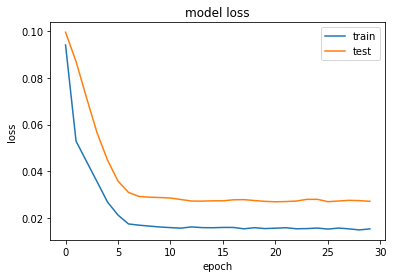

Train Score: 1.44 RMSE
Test Score: 1.94 RMSE


In [81]:
#design and fit our LSTM network
   
model = Sequential()
model.add(LSTM(neurons, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.1))
# model.add(LSTM(neurons))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), verbose=0, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
    
    
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scalerY.inverse_transform(trainPredict)
trainInvY = scalerY.inverse_transform(trainY)
testPredict = scalerY.inverse_transform(testPredict)
testInvY = scalerY.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainInvY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testInvY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

gap: 5
bsize: 10


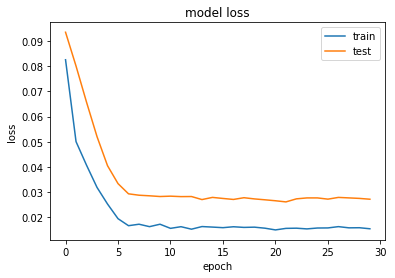

Train Score: 1.44 RMSE
Test Score: 1.94 RMSE
gap: 5
bsize: 10


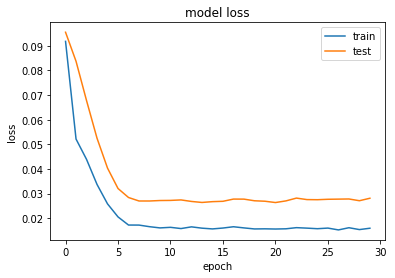

Train Score: 1.45 RMSE
Test Score: 1.97 RMSE
gap: 5
bsize: 10


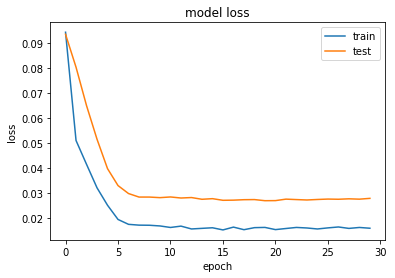

Train Score: 1.45 RMSE
Test Score: 1.96 RMSE
gap: 5
bsize: 10


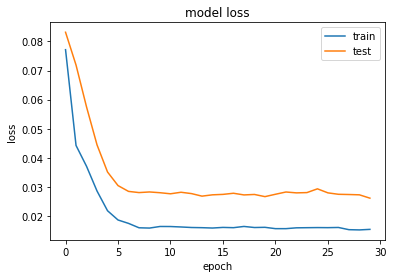

Train Score: 1.43 RMSE
Test Score: 1.90 RMSE
gap: 5
bsize: 10


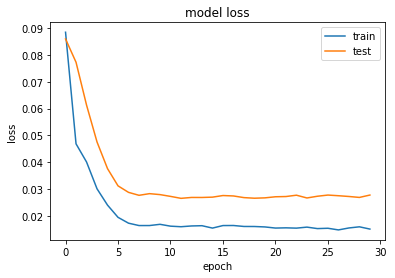

Train Score: 1.45 RMSE
Test Score: 1.96 RMSE
gap: 5
bsize: 10


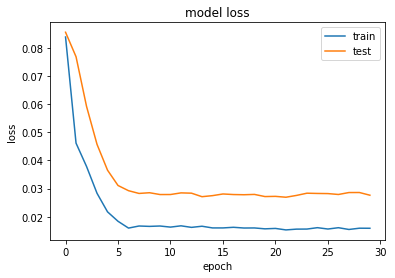

Train Score: 1.45 RMSE
Test Score: 1.96 RMSE
gap: 5
bsize: 10


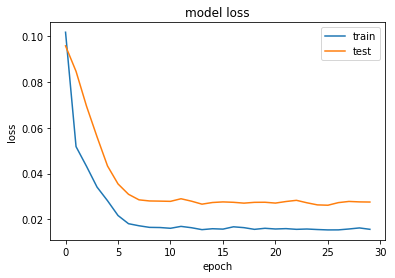

Train Score: 1.44 RMSE
Test Score: 1.96 RMSE
gap: 5
bsize: 10


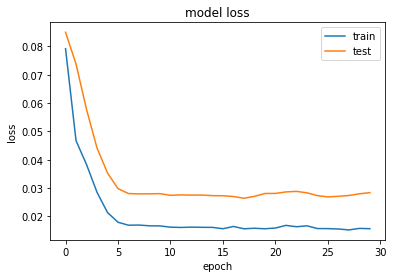

Train Score: 1.46 RMSE
Test Score: 1.98 RMSE
gap: 5
bsize: 10


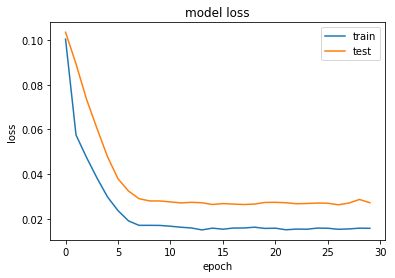

Train Score: 1.44 RMSE
Test Score: 1.94 RMSE
gap: 5
bsize: 10


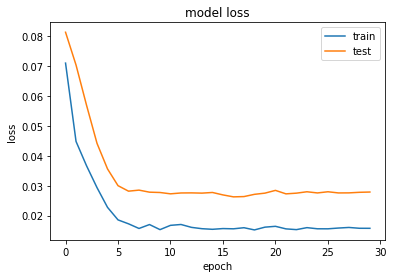

Train Score: 1.45 RMSE
Test Score: 1.97 RMSE


In [13]:
data = []

for gapp in range(5,10):
    for bsizee in range(10,12):
        gap = 5
        bsize = 10
        print('gap: %d\nbsize: %d' % (gap,bsize))
        # frameX = pandas.read_csv('inp.txt', engine='python')
        # setX = frameX.values
        # setX = setX.astype('float32')

        building=2
#         gap=1
        split = 0.67
        neurons = 100
        epochs = 30

        setX, setY = get_data(building, gap)

        # normalize the setX
        scalerX = MinMaxScaler(feature_range=(0, 1))
        setX = scalerX.fit_transform(setX)

        # split into train and test sets
        train_size = int(len(setX) * split)
        test_size = len(setX) - train_size
        train, test = setX[0:train_size,:], setX[train_size:len(setX),:]

        # convert an array of values into a setX matrix
        trainX = numpy.reshape(train, (train.shape[0], 1, train.shape[1]))
        testX = numpy.reshape(test, (test.shape[0], 1, test.shape[1]))

        #Scale

        scalerY = MinMaxScaler(feature_range=(0, 1))
        setY = scalerY.fit_transform(setY)
        trainY, testY = setY[0:train_size,:], setY[train_size:len(setY),:]


        #design and fit our LSTM network

        model = Sequential()
        model.add(LSTM(neurons, input_shape=(trainX.shape[1], trainX.shape[2])))
        model.add(Dropout(0.2))
        # model.add(LSTM(neurons))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history = model.fit(trainX, trainY, epochs=epochs, batch_size=bsize, validation_data=(testX, testY), verbose=0, shuffle=False)
        #bsize = 10
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()


        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)
        # invert predictions
        trainPredict = scalerY.inverse_transform(trainPredict)
        trainInvY = scalerY.inverse_transform(trainY)
        testPredict = scalerY.inverse_transform(testPredict)
        testInvY = scalerY.inverse_transform(testY)
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainInvY, trainPredict[:,0]))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(testInvY, testPredict[:,0]))
        print('Test Score: %.2f RMSE' % (testScore))
        if testScore < 1:
            import winsound
            winsound.Beep(500, 2000)
        data.append([gap,bsize, trainScore, testScore])

In [19]:
with open("Brute_gap_bsize2.pkl", 'wb') as f:
    pickle.dump(data, f)

In [17]:
print(data)

[[5, 1, 1.719838162060727, 2.6554214082758665], [5, 2, 1.6992625965293007, 2.5465000555284494], [5, 3, 1.6983040989739007, 2.4810144500004108], [5, 4, 1.6585084883363694, 2.4093071479000687], [5, 5, 1.5913907709057122, 2.2757321866761107], [5, 6, 1.536348457502556, 2.160905759720349], [5, 7, 1.5126513381782114, 2.1156802284323337], [5, 8, 1.4899446898313755, 2.0565069577215103], [5, 9, 1.4767670666309205, 2.0261959876851683], [6, 1, 1.385110572711576, 1.3928613147393654], [6, 2, 1.6954167769044453, 2.5318131938802386], [6, 3, 1.6792730485459701, 2.4550154866897427], [6, 4, 1.6511438941795773, 2.3962137556046263], [6, 5, 1.5886755548138627, 2.26123052146877], [6, 6, 1.5587475540643634, 2.210833543685671], [6, 7, 1.4976853950382858, 2.085086834789396], [6, 8, 1.494682024435884, 2.065746872808256], [6, 9, 1.4769979975072758, 2.0238945050923283], [7, 1, 1.7186104457726445, 2.6590916412044248], [7, 2, 1.6934223801310428, 2.5344284258948577], [7, 3, 1.6641401532461129, 2.423368620985064], [7

Successfull param combinations: 
 * gap        = 5
 * split      = 0.67
 * neurons    = 100
 * epochs     = 40
 * batch_size = 10
 * Train Score: 0.94 RMSE
 * Test Score: 1.10 RMSE


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scalerY.inverse_transform(trainPredict)
trainInvY = scalerY.inverse_transform(trainY)
testPredict = scalerY.inverse_transform(testPredict)
testInvY = scalerY.inverse_transform(testY)
# calculate root mean squared error
tmp = mean_squared_error(trainInvY, trainPredict[:,0])
trainScore = math.sqrt(tmp)
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testInvY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

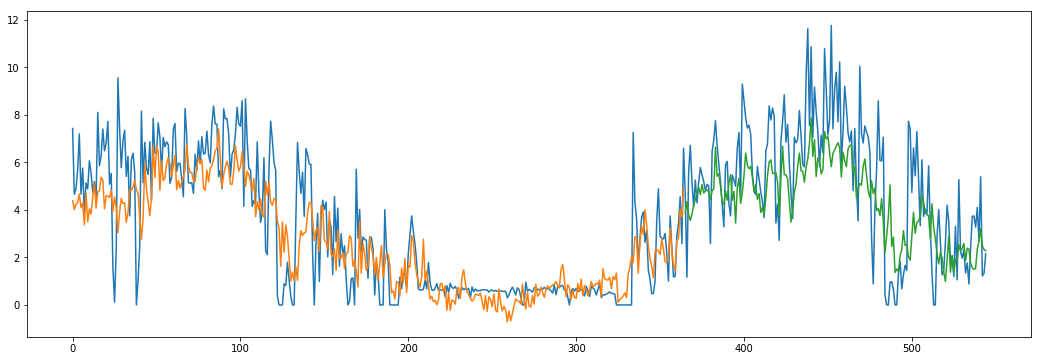

In [22]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(setY)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[:len(trainPredict), :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(setY)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(setY), :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(scalerY.inverse_transform(setY))
ax.plot(trainPredictPlot)
ax.plot(testPredictPlot)
plt.show()

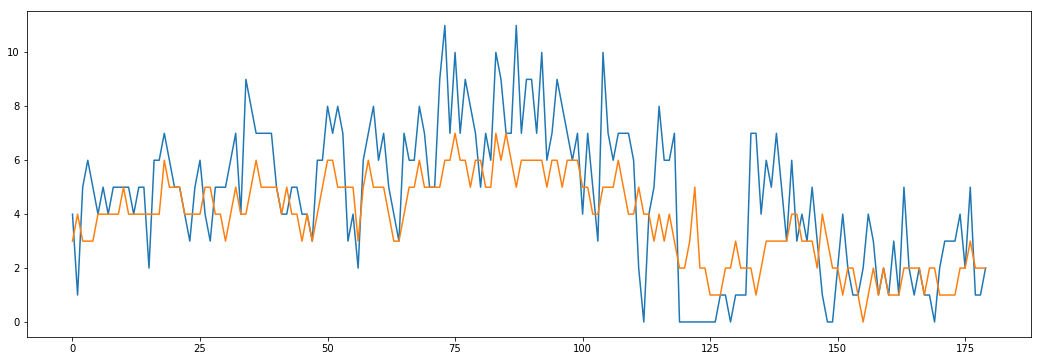

In [23]:
a = list(map(int, scalerY.inverse_transform(setY[len(trainPredict):])))
b = list(map(int, testPredict))
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(a)
ax.plot(b)
plt.show()